In [58]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

#### Setting visualisation style

In [59]:
sns.set(style="whitegrid")

## 1. Feature Engineering: Classify Trade Types

In [60]:
def classify_trade(trade):
    """
    Classify a trade into a type based on 'side' and 'positionSide'.
    """
    side = trade.get('side', None)
    positionSide = trade.get('positionSide', None)
    if side == 'BUY' and positionSide == 'LONG':
        return 'long_open'
    elif side == 'SELL' and positionSide == 'LONG':
        return 'long_close'
    elif side == 'BUY' and positionSide == 'SHORT':
        return 'short_close'
    elif side == 'SELL' and positionSide == 'SHORT':
        return 'short_open'
    else:
        return 'other'



## 2. Process the Trade_History Column

In [61]:
def process_trade_history(df):
    """
    For each row in the DataFrame, convert the Trade_History (if string)
    to a list, then iterate over each trade to create a new row with all trade details,
    along with the Port_IDs and a classified trade type. If there is no trade history,
    assign a default trade_type "none".
    """
    processed_rows = []
    for _, row in df.iterrows():
        port_id = row["Port_IDs"]
        trade_history = row["Trade_History"]
        # Convert string to list if needed
        if isinstance(trade_history, str):
            try:
                trade_history = ast.literal_eval(trade_history)
            except Exception as e:
                trade_history = []
        # For each trade in the list, add a row
        if isinstance(trade_history, list) and trade_history:
            for trade in trade_history:
                trade['trade_type'] = classify_trade(trade)
                processed_row = {"Port_IDs": port_id, **trade}
                processed_rows.append(processed_row)
        else:
            # Add a default trade_type "none" if no trade history
            processed_rows.append({"Port_IDs": port_id, "trade_type": "none"})
    return pd.DataFrame(processed_rows)

## 3. Compute Metrics per Account

In [62]:
def compute_metrics(trades):
    """
    Given the trades for an account, compute key financial metrics:
      - PnL (Profit and Loss)
      - Total Positions (number of trades)
      - Win Positions (trades with positive profit)
      - Win Rate (winning trades / total trades)
      - ROI: (PnL / total investment on BUY trades) * 100
      - Sharpe Ratio: mean / std of realizedProfit (assumes risk-free rate = 0)
      - MDD (Maximum Drawdown)
    """
    # Sort trades by datetime if available
    if 'datetime' in trades.columns:
        trades = trades.sort_values(by="datetime")

    pnl = trades["realizedProfit"].sum() if "realizedProfit" in trades.columns else 0
    total_positions = len(trades)
    win_positions = trades[trades["realizedProfit"] > 0].shape[0] if "realizedProfit" in trades.columns else 0
    win_rate = win_positions / total_positions if total_positions > 0 else np.nan

    # ROI: use the sum of 'quantity' for BUY trades as the investment base
    buy_trades = trades[trades["side"] == "BUY"] if "side" in trades.columns else pd.DataFrame()
    total_investment = buy_trades["quantity"].sum() if (not buy_trades.empty and "quantity" in trades.columns) else np.nan
    roi = (pnl / total_investment) * 100 if total_investment and total_investment != 0 else np.nan

    # Sharpe Ratio: mean / std of realizedProfit
    if total_positions > 1 and trades["realizedProfit"].std() != 0:
        sharpe = trades["realizedProfit"].mean() / trades["realizedProfit"].std()
    else:
        sharpe = np.nan

    # Maximum Drawdown (MDD): based on cumulative profit
    cum_profit = trades["realizedProfit"].cumsum() if "realizedProfit" in trades.columns else pd.Series([0])
    running_max = cum_profit.cummax()
    drawdown = cum_profit - running_max
    mdd = abs(drawdown.min()) if not drawdown.empty else np.nan

    return pd.Series({
        "PnL": pnl,
        "Total_Positions": total_positions,
        "Win_Positions": win_positions,
        "Win_Rate": win_rate,
        "ROI": roi,
        "Sharpe_Ratio": sharpe,
        "MDD": mdd
    })

## 4. Main Analysis Pipeline

In [63]:
def main():
    # Load the dataset (adjust the file path and delimiter as necessary)
    df = pd.read_csv(path)

    # Handle missing values for Trade_History
    df['Trade_History'] = df['Trade_History'].fillna("[]")

    # Process the Trade_History to expand trades into individual rows
    df_processed = process_trade_history(df)

    # Convert 'time' to datetime (if available)
    if 'time' in df_processed.columns:
        df_processed['datetime'] = pd.to_datetime(df_processed['time'], unit='ms')

    # Sort by Port_IDs and datetime if possible
    if 'datetime' in df_processed.columns:
        df_processed.sort_values(by=["Port_IDs", "datetime"], inplace=True)
    else:
        df_processed.sort_values(by=["Port_IDs"], inplace=True)

    # Compute metrics for each account
    metrics_df = df_processed.groupby("Port_IDs").apply(compute_metrics).reset_index()

    # Traditional Ranking (for reference)
    metrics_df["Rank_ROI"] = metrics_df["ROI"].rank(ascending=False, method="min")
    metrics_df["Rank_Sharpe"] = metrics_df["Sharpe_Ratio"].rank(ascending=False, method="min")
    metrics_df["Rank_PnL"] = metrics_df["PnL"].rank(ascending=False, method="min")
    metrics_df["Rank_Win_Rate"] = metrics_df["Win_Rate"].rank(ascending=False, method="min")
    metrics_df["Rank_MDD"] = metrics_df["MDD"].rank(ascending=True, method="min")
    metrics_df["Total_Rank"] = (metrics_df["Rank_ROI"] +
                                metrics_df["Rank_Sharpe"] +
                                metrics_df["Rank_PnL"] +
                                metrics_df["Rank_Win_Rate"] +
                                metrics_df["Rank_MDD"])

    # ---------------------------
    # PCA to Derive Weights for Metrics
    # ---------------------------
    # Prepare a DataFrame for PCA: use ROI, PnL, Sharpe_Ratio, Win_Rate, and invert MDD (because lower is better)
    pca_df = metrics_df[["ROI", "PnL", "Sharpe_Ratio", "Win_Rate", "MDD"]].copy()
    # Fill missing values with the mean for each column
    pca_df = pca_df.fillna(pca_df.mean())
    pca_df["MDD"] = -pca_df["MDD"]  # Invert MDD so that a higher value is better


    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(pca_df)
    pca = PCA(n_components=1)
    pca.fit(scaled_data)
    loadings = pca.components_[0]
    weights = np.abs(loadings) / np.sum(np.abs(loadings))
    print("PCA-derived weights for [ROI, PnL, Sharpe_Ratio, Win_Rate, MDD]:", weights)
    # ---------------------------
    # Compute Standardized Scores (z-scores)
    # ---------------------------
    # For metrics where higher is better, compute z-scores directly.
    for metric in ["ROI", "PnL", "Sharpe_Ratio", "Win_Rate"]:
        metrics_df[metric + "_z"] = (metrics_df[metric] - metrics_df[metric].mean()) / metrics_df[metric].std()
    # For MDD, invert the metric before standardizing (since lower is better)
    metrics_df["MDD_inv"] = -metrics_df["MDD"]
    metrics_df["MDD_inv_z"] = (metrics_df["MDD_inv"] - metrics_df["MDD_inv"].mean()) / metrics_df["MDD_inv"].std()

    # ---------------------------
    # Compute Weighted Overall Score Using PCA-derived Weights
    # ---------------------------
    metrics_df["Weighted_Score"] = (
        metrics_df["ROI_z"] * weights[0] +
        metrics_df["PnL_z"] * weights[1] +
        metrics_df["Sharpe_Ratio_z"] * weights[2] +
        metrics_df["Win_Rate_z"] * weights[3] +
        metrics_df["MDD_inv_z"] * weights[4]
    )
    weighted_ranked_df = metrics_df.sort_values("Weighted_Score", ascending=False).reset_index(drop=True)

    print("Calculated Metrics per Account:")
    print(metrics_df.head())
    print("\nTop 20 Accounts (Traditional Ranking):")
    print(metrics_df.sort_values("Total_Rank").head(20))
    print("\nTop 20 Accounts (PCA Weighted Ranking):")
    print(weighted_ranked_df.head(20))

    metrics_df.to_csv("/content/drive/MyDrive/ML/Projects/PrimeTradeAI Intern/Data/calculated_metrics.csv", index=False)
    weighted_ranked_df.to_csv("/content/drive/MyDrive/ML/Projects/PrimeTradeAI Intern/Data/weighted_ranked_accounts.csv", index=False)

    traditional_df = metrics_df.sort_values("Total_Rank").head(20)
    traditional_df.to_csv("/content/drive/MyDrive/ML/Projects/PrimeTradeAI Intern/Data/traditional_ranked_accounts_20.csv", index=False)
    weighted_ranked_df.head(20).to_csv("/content/drive/MyDrive/ML/Projects/PrimeTradeAI Intern/Data/weighted_ranked_accounts_20.csv", index=False)
    return metrics_df, weighted_ranked_df.head(20), df_processed

In [64]:
path = r"/content/drive/MyDrive/ML/Projects/PrimeTradeAI Intern/Data/data.csv"


### Save the full metrics to a CSV file

# Running the Main

In [65]:
metrics_df, top_20, df_processed = main()

PCA-derived weights for [ROI, PnL, Sharpe_Ratio, Win_Rate, MDD]: [0.1384508  0.40797951 0.04956569 0.01947056 0.38453345]
Calculated Metrics per Account:
              Port_IDs          PnL  Total_Positions  Win_Positions  Win_Rate  \
0  3672754654734989568   566.597660            474.0          210.0  0.443038   
1  3733192481840423936  2923.977200            689.0          553.0  0.802612   
2  3768170840939476993   243.668899             14.0            6.0  0.428571   
3  3784403294629753856  2521.814305           6050.0         1829.0  0.302314   
4  3786761687746711808   205.021400             82.0           37.0  0.451220   

         ROI  Sharpe_Ratio          MDD  Rank_ROI  Rank_Sharpe  ...  \
0   0.917776      0.185274    80.777037      85.0         69.0  ...   
1   0.503462      0.060265  2743.120000     114.0        127.0  ...   
2  31.785505      0.424277     0.000000       1.0         11.0  ...   
3   0.667362      0.106585   271.291981     100.0        104.0  ...   
4   

<ipython-input-63-5c7735fc36cd>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df = df_processed.groupby("Port_IDs").apply(compute_metrics).reset_index()


# Data Visualization (PDA & Graphs)

## Graph 1: Distribution of ROI across accounts

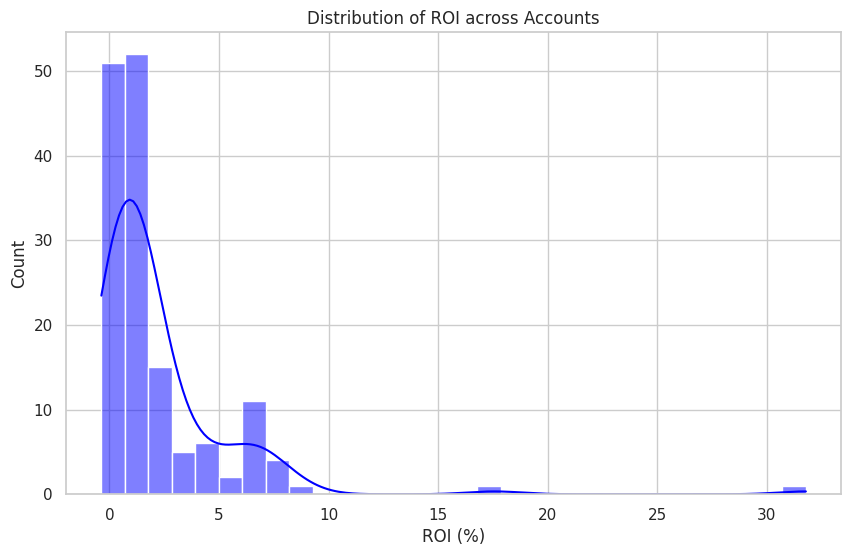

In [66]:
plt.figure(figsize=(10, 6))
sns.histplot(metrics_df["ROI"].dropna(), bins=30, kde=True, color="blue")
plt.title("Distribution of ROI across Accounts")
plt.xlabel("ROI (%)")
plt.ylabel("Count")
plt.show()

## Graph 2: Scatter plot of ROI vs. Sharpe Ratio, marker size indicates PnL

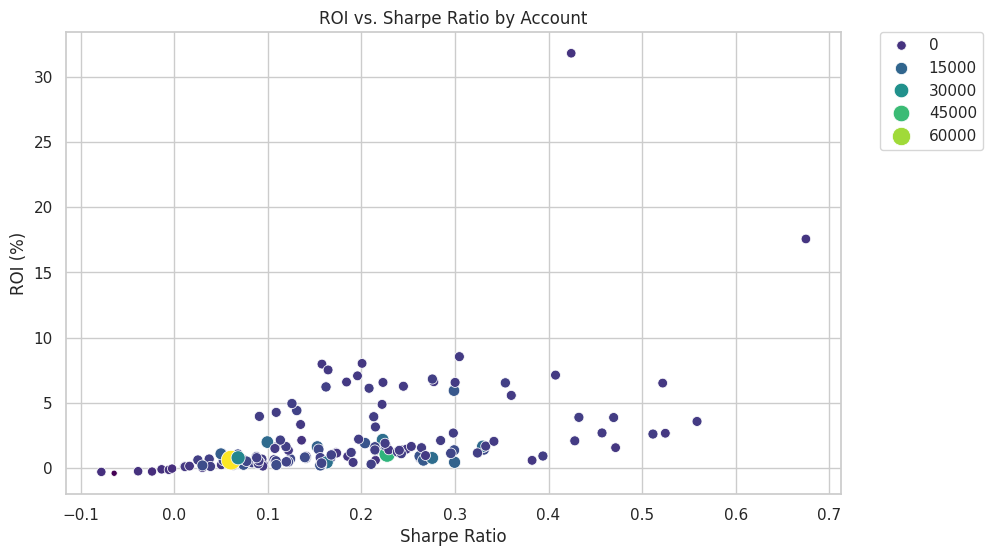

In [67]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=metrics_df, x="Sharpe_Ratio", y="ROI", size="PnL", hue="PnL",
                palette="viridis", sizes=(20, 200))
plt.title("ROI vs. Sharpe Ratio by Account")
plt.xlabel("Sharpe Ratio")
plt.ylabel("ROI (%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Graph 3: Bar plot of Total Rank for the Top 20 Accounts

<ipython-input-68-0cffd25e3fbf>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20, x="Port_IDs", y="Total_Rank", palette="muted")


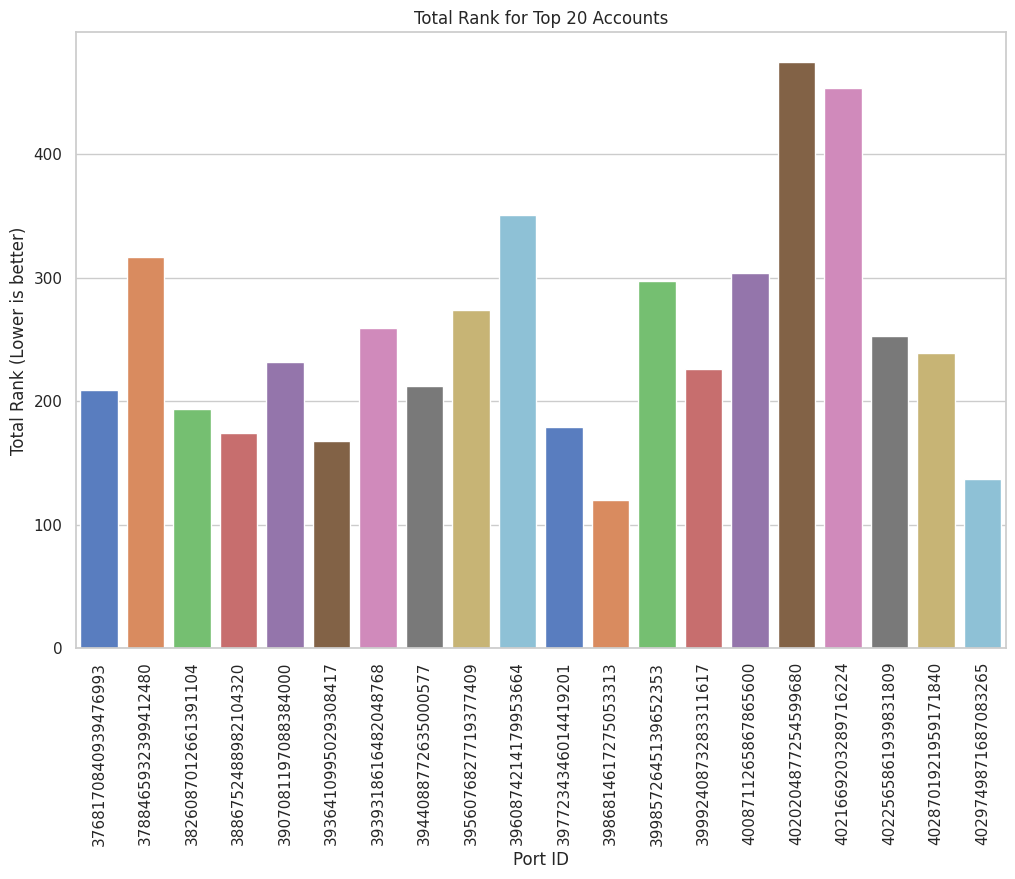

In [68]:
plt.figure(figsize=(12, 8))
sns.barplot(data=top_20, x="Port_IDs", y="Total_Rank", palette="muted")
plt.title("Total Rank for Top 20 Accounts")
plt.xlabel("Port ID")
plt.ylabel("Total Rank (Lower is better)")
plt.xticks(rotation=90)
plt.show()


## Graph 4: Frequency distribution of Trade Types across all trades

In [69]:

df_processed.columns = df_processed.columns.str.strip()

if 'trade_type' not in df_processed.columns:
    df_processed['trade_type'] = 'none'
else:
    df_processed['trade_type'] = df_processed['trade_type'].fillna('none')

print(df_processed.columns)


Index(['Port_IDs', 'time', 'symbol', 'side', 'price', 'fee', 'feeAsset',
       'quantity', 'quantityAsset', 'realizedProfit', 'realizedProfitAsset',
       'baseAsset', 'qty', 'positionSide', 'activeBuy', 'trade_type',
       'datetime'],
      dtype='object')


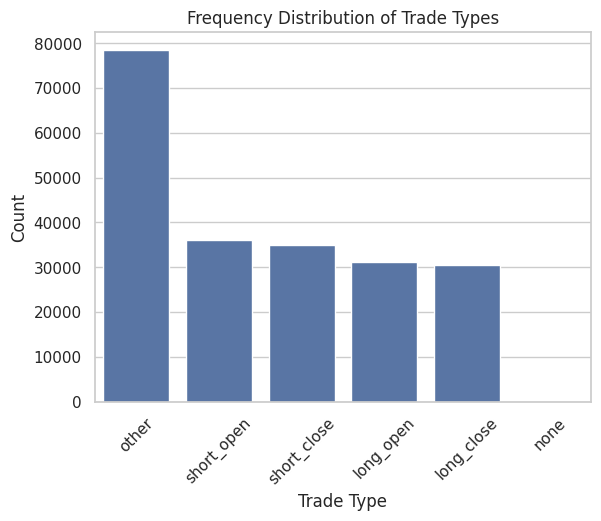

In [70]:
# Filter out rows with default "none" if desired, or keep them
sns.countplot(data=df_processed, x="trade_type", order=df_processed["trade_type"].value_counts().index)
plt.title("Frequency Distribution of Trade Types")
plt.xlabel("Trade Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Trash